<a href="https://colab.research.google.com/github/Khanlary/Anomaly-detection-LLM/blob/main/Comet_Data_Panels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://cdn.comet.ml/img/notebook_logo.png">

# ☄ Comet Data Panels

Comet’s long-standing mission is to help Data Scientists and Machine Learning Engineers find the best model for their use-case by arming them with powerful tools and visualizations. In an effort to continue to deliver on this mission, we are excited to launch our new built-in panel: **The Data Panel**. The Data Panel allows users to visualize and interact with their tabular data and aggregate tables across Experiments. The Panel works out of the box with pandas dataframes and .csv files.

To showcase our new Data Panel, we’ve put together a public project using [Kaggle’s Credit Card Fraud Detection dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). View the [Comet public project here](https://www.comet.com/anmorgan24/datapanels/view/ndkH4IkEmrTdYr0hvO97AxjeY/panels?utm_source=Medium&utm_medium=referral&utm_content=data_panels_blog).


## 🔩 Install requirements & set up
_____

In [ ]:
pip install comet_ml torch torchvision tqdm --quiet

     |████████████████████████████████| 449 kB 20.7 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 174 kB 73.8 MB/s 
     |████████████████████████████████| 54 kB 3.9 MB/s 
     |████████████████████████████████| 502 kB 75.6 MB/s 
     |████████████████████████████████| 139 kB 65.2 MB/s 
     |████████████████████████████████| 140 kB 81.5 MB/s 
     |████████████████████████████████| 127 kB 64.6 MB/s 
     |████████████████████████████████| 173 kB 80.1 MB/s 
     |████████████████████████████████| 168 kB 82.1 MB/s 
     |████████████████████████████████| 168 kB 81.5 MB/s 
     |████████████████████████████████| 166 kB 76.3 MB/s 
     |████████████████████████████████| 166 kB 81.7 MB/s 
     |████████████████████████████████| 162 kB 78.2 MB/s 
     |████████████████████████████████| 162 kB 79.1 MB/s 
     |████████████████████████████████| 158 kB 69.1 MB/s 
     |████████████████████████████████| 157 kB 76.5 MB/s 
     |████████████

To instantiate your Comet Experiment, you'll need to grab your API key from your [account settings](https://www.comet.com/account-settings/profile?utm_source=Medium&utm_medium=referral&utm_content=data_panels_blog). If you don't already have an account, [create one here for free](https://www.comet.com/signup?utm_source=Medium&utm_medium=referral&utm_content=data_panels_blog).

In [ ]:
import comet_ml
from comet_ml import Experiment

experiment = Experiment(
    api_key = "<YOUR-API-KEY>",
    project_name = "datapanels",
    workspace = "anmorgan24"
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: Failed to calculate active processors count. Fall back to default CPU count 1
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/anmorgan24/datapanels/a63a5bd929e9463dab2269ceeb75e8f6



In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import matplotlib.image as img
import seaborn as sns

To run the following cell, first upload a `kaggle.json` file with your Kaggle credentials.

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mlg-ulb/creditcardfraud; unzip creditcardfraud.zip; rm creditcardfraud.zip

 65% 43.0M/66.0M [00:00<00:00, 233MB/s]
100% 66.0M/66.0M [00:00<00:00, 243MB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


## 🛠 Data preparation
_____


[Fraud detection](https://heartbeat.comet.ml/fraud-detection-imbalanced-classification-and-managing-your-machine-learning-experiments-using-224ecf00bf7e) comes with its own set of unique challenges. Fraudulent transactions represent anomalous data that make up a very small percentage of total transactions. These significant [class imbalances](https://heartbeat.comet.ml/imbalanced-classification-demystified-66a401d6e805) make many traditional evaluation metrics, like [accuracy](https://machinelearningmastery.com/failure-of-accuracy-for-imbalanced-class-distributions/), irrelevant. In the Kaggle dataset, fraud makes up just 0.172% of all transactions, meaning a model that predicted “no fraud” for every single observation would still achieve an accuracy of over 98%!

In the pie chart below, fraudulent transactions are represented by the tiny orange sliver!


In [ ]:
data = pd.read_csv('creditcard.csv')

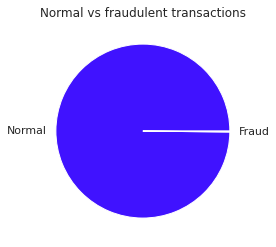

In [ ]:
orange, purple = '#ffa022', '#4012ff'
fig, ax = plt.subplots()
ax.pie(data.groupby(['Class']).Class.count(), labels= ['Normal', 'Fraud'], colors=[purple, orange])
plt.title('Normal vs fraudulent transactions')
plt.show()

Additionally, in order to protect all personally identifiable information ([PII](https://www.techtarget.com/searchsecurity/definition/personally-identifiable-information-PII)) in this dataset, all features (besides `Time` and `Amount`) have undergone a [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) transformation. This means that we cannot use any domain knowledge for the purposes of feature engineering or selection.

Let's start out by visualizing our data. It would be impossible to plot 30 dimensions, so first we'll apply [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), a dataset decomposition technique, and plot the 2 components with maximum information.

In [ ]:
#data = pd.read_csv('creditcard.csv')

# Take a random sample of 1000 normal transactions and all fraud transactions
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

# Shuffle fraud and non_fraud samples and separate into features and labels
df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
y = df["Class"].values

In [ ]:
def tsne_plot(X, y, name, title='TSNE plot of Fraud and Non Fraud'):
  tsne = TSNE(n_components=2, random_state=24, init='random', learning_rate=200)
  X_t = tsne.fit_transform(X)

  plt.figure(figsize=(12,8))
  plt.scatter(X_t[np.where(y==0), 0], X_t[np.where(y==0), 1], color='darkorange', alpha = 0.7, label = "Non Fraud")
  plt.scatter(X_t[np.where(y==1), 0], X_t[np.where(y==1), 1], color='mediumblue', alpha = 0.7, label = "Fraud")

  plt.legend(loc='best')
  plt.title(title, fontsize=16)
  experiment.log_figure(figure=plt)
  plt.savefig(name)
  plt.show()

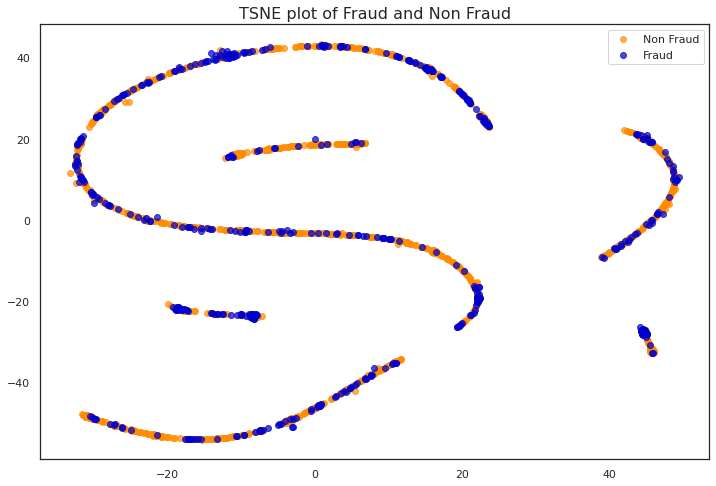

In [ ]:
tsne_plot(X, y, name="original.png")

We can observe in this graph that there is little difference between fraudulent and non-fraudlent transactions. [Most machine learning models would struggle to classify this data as-is](https://machinelearningmastery.com/imbalanced-classification-is-hard/).

First, we'll perform some very basic transformations to the data before feeding it to our model. The original **`Time`** feature represents the number of seconds elapsed between each transaction and the first transaction in the data. We'll convert this relative time measure to hour-of-the-day.

We also scale the **`Time`** and **`Amount`** features, as all other features (**`V1`**, **`V2`**, ... **`V28`**) were previously scaled during the PCA transformation. Finally, because we are training an autoencoder to “learn” the embeddings of a normal transaction, we’ll subset just normal samples as our training dataset, and use a 50:50 split of normal and fraudulent samples for our validation set. We'll also set aside 250 samples for a test dataset of completely unseen data.

In [ ]:
# Convert relative 'Time' measure to hour of day
data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24)

# Scale 'Time' and 'Amount'
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data['Time'] = StandardScaler().fit_transform(data['Time'].values.reshape(-1, 1))

# Separate fraudulent transactions from normal transactions
norm_data, fraud_data = data[data['Class']==0], data[data['Class']==1]

# Training data will be 2000 normal samples
# Validation data will be 1000 samples, approximately half fraud and half normal samples; shuffled and with indices reset
# We leave out 200 normal samples and 50 fraud samples for a final test dataset of 250 unseen samples; we'll choose a random subsample of these later
train_data = norm_data.iloc[:2000, :]
val_data = pd.concat([norm_data.iloc[2000:2558,:], fraud_data.iloc[:442, :]], axis =0).sample(frac=1).reset_index(drop=True)
test_samples = pd.concat([norm_data.iloc[2558:2608,:], fraud_data.iloc[442:,:]], axis=0).sample(frac=1).reset_index(drop=True)

## 🦾 Model training and inference
_____

While there are various ways to approach this problem, one of the simplest and most effective is to use an autoencoder. Autoencoders learn an implicit representation of normality from the abundant “normal” samples, allowing us to reserve our sparse fraudulent data samples for testing. During inference, new samples are compared against the embeddings of normal samples to determine whether or not they are fraudulent.  While Deep Learning techniques aren’t applied to tabular data as often as [unstructured data](https://en.wikipedia.org/wiki/Unstructured_data), the stark class imbalances in this dataset make it a perfect candidate for use with an autoencoder.

First we'll define our model hyperparameters and create DataLoader objects for our training and validation splits.

In [ ]:
# These hyperparameters will be logged
hyper_params = {
    "learning_rate": 1e-1/10,
    "epochs": 150,
    "batch_size": 32,
    "weight_decay": 1e-8,
    'threshold': 0.75
}

experiment.log_parameters(hyper_params)

In [ ]:
# Create pytorch data loader for training set
train_target = torch.tensor(train_data['Class'].values.astype(np.float32))
train = torch.tensor(train_data.drop('Class', axis = 1).values.astype(np.float32))
train_tensor = data_utils.TensorDataset(train, train_target)
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = hyper_params['batch_size'], shuffle = True)

# Create pytorch data loader for validation set
val_target = torch.tensor(val_data['Class'].values.astype(np.float32))
val = torch.tensor(val_data.drop('Class', axis = 1).values.astype(np.float32))
val_tensor = data_utils.TensorDataset(val, val_target)
val_loader = data_utils.DataLoader(dataset = val_tensor, batch_size = 1, shuffle = True)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(30,14),
            nn.Tanh(),
            nn.Linear(14,7),
            nn.Tanh(),
            )
        self.decoder = nn.Sequential(
            nn.Linear(7, 14),
            nn.Tanh(),
            nn.Linear(14,30),
            nn.Tanh()
            )
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=hyper_params["learning_rate"],
                             weight_decay=hyper_params['weight_decay'])

In [ ]:
for epoch in range(hyper_params['epochs']):
    losses = []
    for (data, _) in train_loader:
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    # ===================log========================
    experiment.log_metric('epoch_loss', np.mean(losses), epoch = epoch+1)

    losses = []
    labels = []
    preds = []
    embeds = []

    for data, label in val_loader:
        # ===================forward=====================
        reconstructed = model(data)
        loss = torch.sigmoid(criterion(reconstructed, data)).item()
        losses.append(round((loss),6))
        labels.append(label.item())
        preds.append(reconstructed[0][-1].item())
        embeds.append(reconstructed[0][:-1].detach().cpu().numpy())

    # ===================log========================
    experiment.log_metric('val_loss', np.mean(losses), epoch = epoch +1)

    if epoch == (hyper_params["epochs"] - 1):
      print("logging table")
      df = pd.DataFrame()
      df['Reconstruction_Loss'] = losses
      df['Labels_gt'] = labels
      df['Labels_preds']= [int(x >= hyper_params['threshold']) for x in losses]
      experiment.log_table('val_predictions.csv', df)
print('complete')

logging table
complete


## ⤴ Precision-recall curve, threshold values, classification report
____

##### Define plot functions

In [ ]:
def plot_precision_recall_curves(df):
  # Calculate precision and recall
  precision, recall, thresholds = precision_recall_curve(labels, preds)

  # Plot recall precision tradeoff
  sns.set(style="white")
  plt.figure(figsize=(8,6))
  plt.step(recall, precision, color= purple, alpha=0.4, where='post')
  plt.fill_between(recall,precision,step='post',alpha=0.2,color=purple)
  plt.title('Recall vs Precision', fontsize=16)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  experiment.log_figure(figure=plt)
  #plt.savefig('precision_recall_curve_x.png')
  print(plt.show())

  # Plot precision and recall for different thresholds
  plt.figure(figsize=(8,6))
  plt.plot(thresholds, precision[1:], label="Precision",color= orange, linewidth=2.5)
  plt.plot(thresholds, recall[1:], label="Recall",color= purple, alpha=0.9,linewidth=2.5)
  plt.title('Precision and recall for different threshold values', fontsize=16)
  plt.xlabel('Threshold')
  plt.ylabel('Precision/Recall')
  plt.legend()
  experiment.log_figure(figure=plt)
  #plt.savefig('threshold_values_x.png')
  plt.show()

In [ ]:
def reconstruction_error_plot(df, ylims = (None, None), title="Reconstruction error for different classes"):
  groups = df.groupby('Labels_gt')
  sns.set(style="white")
  sns.set_palette(sns.color_palette([orange, purple]))
  fig, ax = plt.subplots(figsize=(8,6))

  for name, group in groups:
    ax.plot(group.index,
            group.Reconstruction_Loss,
            marker='o',
            ms=5,
            linestyle='',
            label= "Fraud" if name == 1 else "Nonfraud")

  ax.hlines(hyper_params['threshold'],
            ax.get_xlim()[0],
            ax.get_xlim()[1],
            colors="r",
            zorder=100,
            label='Threshold',
            linestyle='--')
  ax.legend()
  plt.title(title, fontsize=16)
  plt.ylabel("Reconstruction error")
  plt.xlabel("Data point index")
  plt.ylim(top=ylims[0], bottom=ylims[1])
  plt.legend(loc='best')
  experiment.log_figure(figure=plt)
  #plt.savefig('reconstruction_error_plot_x.png')
  plt.show()

##### Plot metrics

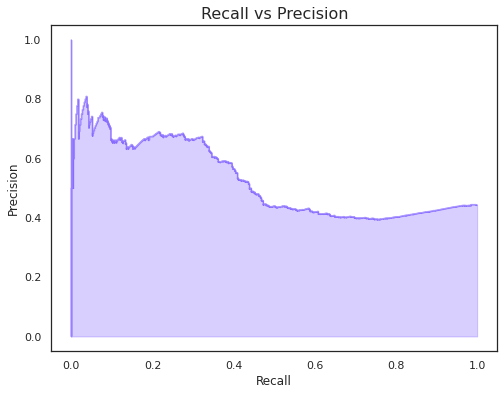

None


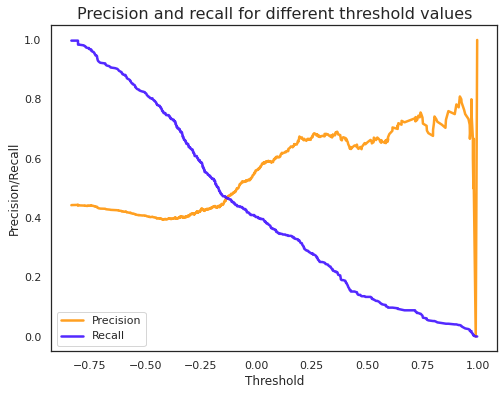

In [ ]:
plot_precision_recall_curves(df)

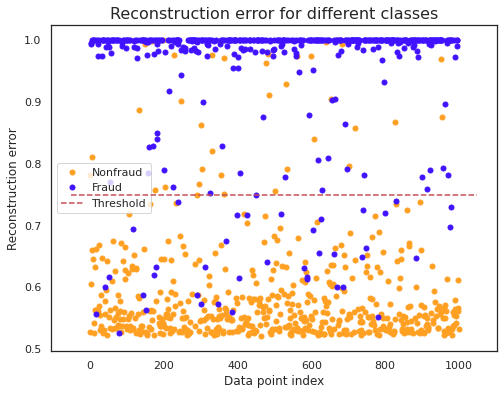

In [ ]:
reconstruction_error_plot(df)

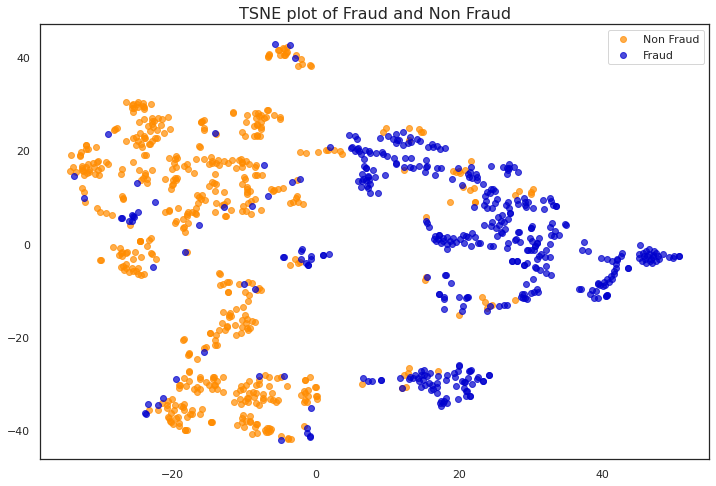

In [ ]:
X = np.array(embeds)
y=df['Labels_gt'].values
tsne_plot(X, y, name='latent_rep.png')

Let's take a look at the plot of our original dataset t-SNE plot versus that of our autoencoder embeddings:

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

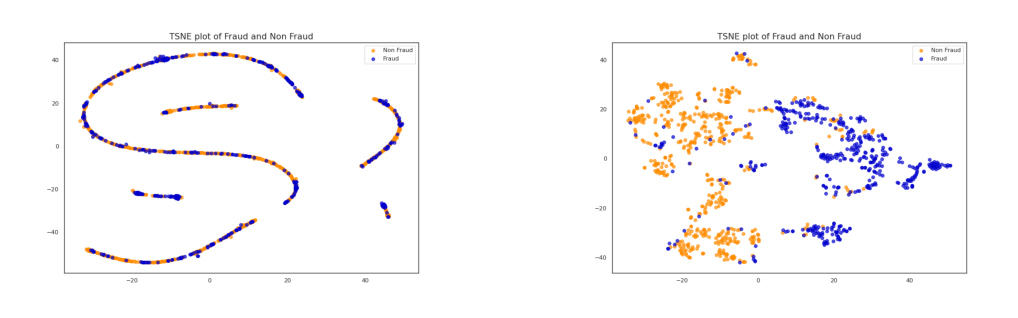

In [ ]:
sns.set(style="white")
plt.figure(figsize=(18,12))

plt.subplot(1, 2, 1)
plt.imshow(img.imread('original.png'))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img.imread('latent_rep.png'))
plt.axis('off')

plt.tight_layout

Clearly, the embeddings learned by our Autoencoder (on the right) are much easier to separate than the raw data (on the left).

In [ ]:
print("Classification report \n {0}".format(classification_report(df.Labels_gt, df.Labels_preds)))

Classification report 
               precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       558
         1.0       0.91      0.91      0.91       442

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



Now our model is ready to be tested on new, unseen data. We’ll log the summary statistics of our test dataset to monitor for any data distribution shifts or disturbances. Later, we'll also be able to reference this metadata to help explain any unusual or unexpected outputs. The code snippet below logs the summary statistics of our test dataset as a csv file called “input_statistics”:

In [ ]:
# We take 10 random samples from the unseen test set we defined earlier
test_data = test_samples.sample(10).reset_index(drop=True)

# Log summary statistics of test data (only 5 columns, round to 4 decimal places)
experiment.log_table('input_statistics.csv', test_data.describe().iloc[:,[0, 1, 2, 29, 30]].round(4))

{'web': 'https://www.comet.com/api/asset/download?assetId=a46481985b0c4ee6ad445cdd2a9555c8&experimentKey=a63a5bd929e9463dab2269ceeb75e8f6',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=a46481985b0c4ee6ad445cdd2a9555c8&experimentKey=a63a5bd929e9463dab2269ceeb75e8f6',
 'assetId': 'a46481985b0c4ee6ad445cdd2a9555c8'}

Once we've completed training and inference, we can head over to the Comet UI to check out our Data Panels! Because we're using an interactive environment, first we'll call **`experiment.end()`** to ensure all logged tables are successfully uploaded.

In [ ]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/anmorgan24/datapanels/a63a5bd929e9463dab2269ceeb75e8f6
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch_loss [150] : (0.4233178496360779, 0.7096998691558838)
COMET INFO:     loss [945]       : (0.16675914824008942, 4.768341064453125)
COMET INFO:     val_loss [150]   : (0.75006423, 0.77255699)
COMET INFO:   Parameters:
COMET INFO:     algorithm     : auto
COMET INFO:     batch_size    : 32
COMET INFO:     copy          : True
COMET INFO:     epochs        : 150
COMET INFO:     leaf_size     : 30
COMET INFO:     learning_rate : 0.01
COMET INFO:     metric        : euclidean
COMET INFO:     metric_params : 1
COMET INFO:     n_jobs        : 1
COMET INFO:     n_neighbors   : 91
COMET INFO:     p             : 2
COMET INFO:     radius   

## ⚙ Using Data Panels

____

To add the Data Panels to your default view in the Comet UI, you can access them directly in the built-in panel options:

[![add_Comet_data_panels.gif](https://s9.gifyu.com/images/add_data_panels.gif)](https://www.comet.com/site/)

Not detecting fraudulent cases when they are actually occurring could potentially cost banks and other financial institutions a lot of money. Let's take a look at instances where the ground truth label for a sample was fraud, but our model predicted no fraud ([false negatives](https://en.wikipedia.org/wiki/False_positives_and_false_negatives)).

[![CometDataPanels_misclassifying.gif](https://s9.gifyu.com/images/DP_misclassifying.gif)](https://www.comet.com/site/)

One of the most useful ways to use the Data Panel is to track how prediction columns are changing for the same samples across experiments. Concatenate the tables via columns and see side-by-side how your prediction columns are comparing to previous runs.

[![DataPanels_concatenate_columns.gif](https://s9.gifyu.com/images/DP_concatenate_columns.gif)](https://www.comet.com/site/)

If you have any feedback, or for help and support with Data Panels, please join the [Comet Community Slack channel](https://cometml.slack.com/join/shared_invite/zt-1fa356mer-2AMqwrzobWAJNx1oo1KSpQ#/shared-invite/email?utm_source=Medium&utm_medium=referral&utm_content=data_panels_blog).